In [8]:
import jupyterconfig
import matplotlib.pyplot as plt
import dbtools as dbt
import datetime
import seaborn as sns

sns.set()
%matplotlib inline

Text(0.5, 1.0, 'Total Tweets vs. Date')

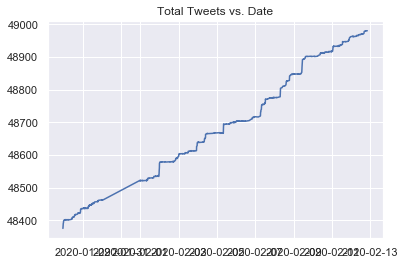

In [11]:
rdt_q  = """
SELECT * FROM tweetcounts
WHERE "user" = 'realDonaldTrump'
"""

df = dbt.select(rdt_q, con=dbt.PI_PROD)
df['prevt'] = df['tweets'].shift(1)
df = df[df['tweets']!=df['prevt']]

plt.plot(df['update_ts'], df['tweets'])
plt.title('Total Tweets vs. Date')